In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.sqlcontroller import SqlController

In [34]:
def sort_from_center(polygon):
    coords = np.array(polygon)
    center = coords.mean(axis=0)
    centered = coords - center
    angles = -np.arctan2(centered[:,1], centered[:,0])
    sorted_coords = coords[np.argsort(angles)]
    return list(map(tuple, sorted_coords)), center, angles

def interpolate2d(points, new_len):
    '''
    Interpolates a list of tuples to the specified length. The points param
    must be a list of tuples in 2d
    :param points: list of floats
    :param new_len: integer you want to interpolate to. This will be the new
    length of the array
    There can't be any consecutive identical points or an error will be thrown
    unique_rows = np.unique(original_array, axis=0)
    '''
    points = np.array(points)
    lastcolumn = np.round(points[:,-1])
    z = mode(lastcolumn)
    points2d = np.delete(points, -1, axis=1)
    pu = points2d.astype(int)
    indexes = np.unique(pu, axis=0, return_index=True)[1]
    points = np.array([points2d[index] for index in sorted(indexes)])
    addme = points2d[0].reshape(1, 2)
    points2d = np.concatenate((points2d, addme), axis=0)

    tck, u = splprep(points2d.T, u=None, s=3, per=1)
    u_new = np.linspace(u.min(), u.max(), new_len)
    x_array, y_array = splev(u_new, tck, der=0)
    arr_2d = np.concatenate([x_array[:, None], y_array[:, None]], axis=1)
    arr_3d = np.c_[ arr_2d, np.zeros(new_len)+z ] 
    return list(map(tuple, arr_3d))


def is_convex_polygon(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    """
    TWO_PI = 2 * math.pi
    polygon = [(int(x[0]), int(x[1])) for x in polygon]

    try:  # needed for any bad points or direction changes
        # Check for too few points
        if len(polygon) < 3:
            return False
        # Get starting information
        old_x, old_y = polygon[-2]
        new_x, new_y = polygon[-1]
        print('old', old_x, old_y)
        print('old', new_x, new_y)
        new_direction = math.atan2(new_y - old_y, new_x - old_x)
        angle_sum = 0.0
        # Check each point (the side ending there, its angle) and accum. angles
        for ndx, newpoint in enumerate(polygon):
            print(ndx, newpoint)
            # Update point coordinates and side directions, check side length
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = math.atan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                print('check 1')
                return False  # repeated consecutive points
            # Calculate & check the normalized direction-change angle
            angle = new_direction - old_direction
            if angle <= -math.pi:
                angle += TWO_PI  # make it in half-open interval (-Pi, Pi]
            elif angle > math.pi:
                angle -= TWO_PI
            if ndx == 0:  # if first time through loop, initialize orientation
                if angle == 0.0:
                    print('check 2')
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:  # if other time through loop, check orientation is stable
                if orientation * angle <= 0.0:  # not both pos. or both neg.
                    print('check 3')
                    return False
            # Accumulate the direction-change angle
            angle_sum += angle
        # Check that the total number of full turns is plus-or-minus 1
        result = abs(round(angle_sum / TWO_PI))
        print('check 4', result)

        return abs(round(angle_sum / TWO_PI)) == 1
    except (ArithmeticError, TypeError, ValueError) as err:
        print('check 5', err)

        return False  # any exception means not a proper convex polygon

    
def zCrossProduct(a,b,c):
   return (a[0]-b[0])*(b[1]-c[1])-(a[1]-b[1])*(b[0]-c[0])

def is_convex(vertices):
    if len(vertices)<4:
        return True
    signs= [zCrossProduct(a,b,c)>0 for a,b,c in zip(vertices[2:],vertices[1:],vertices)]
    return all(signs) or not any(signs)

In [26]:
polygon = [(37755.692307692305, 10026.276923076923, 236), (36032.92307692308, 14735.692307692309, 236), (36109.53846153846, 16994.676923076924, 236), (42273.84615384615, 19253.661538461536, 236), (45260.307692307695, 19483.384615384617, 236), (45375.07692307692, 16726.64615384615, 236), (43881.846153846156, 12974.430769230768, 236), (40678.153846153844, 9906.984615384616, 236)]
polygon = [(0,1),(1,1),(0,1),(0,0)]
is_convex_polygon(polygon)

old 0 1
old 0 0
0 (0, 1)
1 (1, 1)
check 3


False

In [9]:
lim = 1400
polygon = [(974.1384615384616, 732.5907692307693, 146), (946.1261538461538, 760.5999999999999, 146), (946.1261538461538, 760.5999999999999, 146), (918.116923076923, 810.0338461538462, 146), (918.116923076923, 810.0338461538462, 146), (873.6276923076922, 870.996923076923, 146), (873.6276923076922, 870.996923076923, 146), (855.5015384615384, 902.3046153846154, 146), (855.5015384615384, 902.3046153846154, 146), (895.0492307692308, 907.2492307692307, 146), (895.0492307692308, 907.2492307692307, 146), (914.8215384615385, 905.5999999999999, 146), (914.8215384615385, 905.5999999999999, 146), (954.3661538461538, 864.4092307692307, 146), (954.3661538461538, 864.4092307692307, 146), (990.6153846153845, 801.7938461538462, 146), (990.6153846153845, 801.7938461538462, 146), (1003.796923076923, 783.6707692307692, 146), (1003.796923076923, 783.6707692307692, 146), (974, 732, 146)]
p = [(int(x[0]), lim-int(x[1])) for x in polygon]
print(p)
print()
is_convex_polygon(p)

[(974, 668), (946, 640), (946, 640), (918, 590), (918, 590), (873, 530), (873, 530), (855, 498), (855, 498), (895, 493), (895, 493), (914, 495), (914, 495), (954, 536), (954, 536), (990, 599), (990, 599), (1003, 617), (1003, 617), (974, 668)]

old 974 668
old 946 640
0 (974, 668)
1 (946, 640)
2 (946, 640)
check 1


False

False


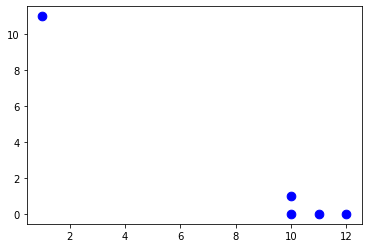

In [40]:
p = ((0,0), (1,0), (1,1), (0,1))
# p = ((0,1),(1,1),(0,1),(0,0))
p = [(10,0), (12,0), (11,0), (1,11), (10,1)]
convex = is_convex( p )
print(convex)
p_arr = np.array(p)
xs = p_arr[:,0]
ys = p_arr[:,1]
fig, ax = plt.subplots()
#ax.invert_yaxis()
#ax.invert_xaxis()
ax.scatter(x=xs, y=ys, c='b', s=75, label='polygon')
#ax.set_xlim([0, 1200])
#ax.set_ylim([0,lim])

In [ ]:
sorted_points2, center, angles = sort_from_center_np(polygon)

In [ ]:
print(sorted_points2)
print(angles)

In [ ]:
sorted_points = np.array(sorted_points2)
xs = sorted_points[:,0]
ys = sorted_points[:,1]
#xus = unsorted_points[:,0]
#yus = unsorted_points[:,1]

In [ ]:
X = xs.tolist()
Y = ys.tolist()
y0 = center[1]
x0 = center[0]

for x,y in zip(X,Y):    
    angle_degrees = math.degrees(math.atan2(y0 - y, x0 - x)) % 360
    angle_radians = math.atan2(y0 - y, x0 - x)
    print(x,y,angle_degrees, angle_radians)

In [ ]:
xs

In [ ]:
point1 = [1, 2]
point2 = [3, 4]

x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]

y0 = center[1]
x0 = center[0]
nd = [int(math.degrees(math.atan2(y0 - y, x0 - x))) % 360 for y,x in zip(ys,xs)]
nr = [round(math.atan2(y0 - y, x0 - x),2) for y,x in zip(ys,xs)]

fig, ax = plt.subplots()
ax.invert_yaxis()
ax.scatter(x=center[0], y=center[1], s=200, c='r', label='Centroid')  # use this to plot a single point
ax.scatter(x=xs, y=ys, c='b', s=75, label='Cerebellum')
ax.legend(bbox_to_anchor=(1.1, 1.1))
#ax.scatter(z, y)
for i, txt in enumerate(nr):
    x_values = [center[0], xs[i]]
    y_values = [center[1], ys[i]]
    plt.plot(x_values, y_values)
    ax.annotate(txt, (xs[i], ys[i]), fontsize=20)